In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import pandas as pd
import numpy as np
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
import gc
import wandb

In [2]:
train_terms = pd.read_csv("../input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)
train_terms.head()

(5363863, 3)


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [3]:
train_terms.tail()

,EntryID,term,aspect
5363858,X5L565,GO:0050649,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO
5363862,X5M5N0,GO:0003674,MFO


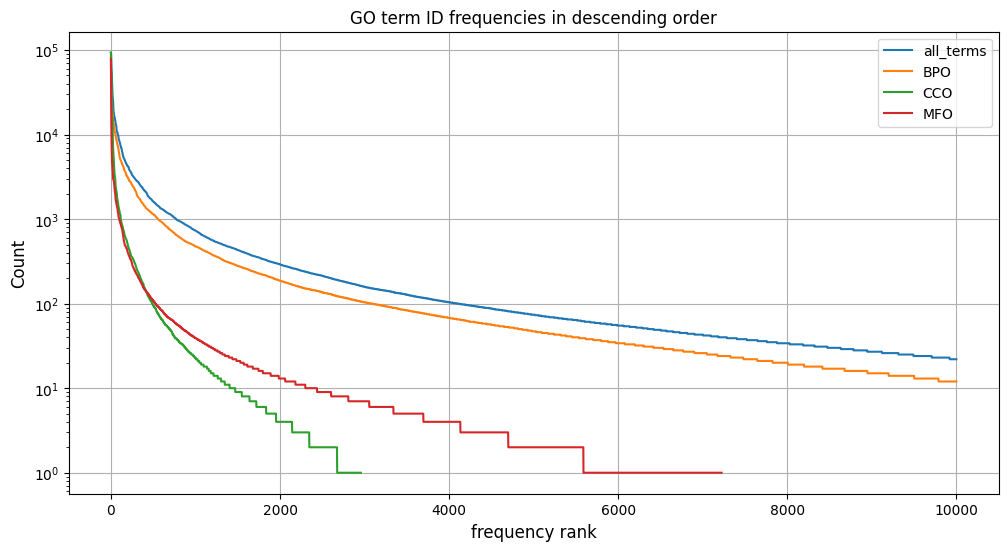

In [4]:
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

plot_df = train_terms['term'].value_counts()[:10000]
bp = sns.lineplot(ax=axis, x =list(range(len(plot_df))), y=plot_df.values, label='all_terms')

for ont in ['BPO', 'CCO', 'MFO']:
    ont_df = train_terms[train_terms['aspect'] == ont]['term'].value_counts()[:10000]
    sns.lineplot(ax=axis, x =list(range(len(ont_df))), y=ont_df.values, label=ont)

axis.set_title('GO term ID frequencies in descending order')
plt.xlabel("frequency rank", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.yscale('log')
plt.grid()
plt.show()

At top 1000 at each ontology, each term has at least ~30 samples. 

In [5]:
# Take 1000 labels of each ontology but 2000 from BPO
num_of_labels = 1000
labels_bpo = train_terms[train_terms['aspect'] == 'BPO']['term'].value_counts().index[:num_of_labels * 2].tolist()
labels_cco = train_terms[train_terms['aspect'] == 'CCO']['term'].value_counts().index[:num_of_labels].tolist()
labels_mfo = train_terms[train_terms['aspect'] == 'MFO']['term'].value_counts().index[:num_of_labels].tolist()
labels_all = labels_bpo + labels_cco + labels_mfo

In [6]:
len(labels_all)

4000

In [7]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels_all)]

In [8]:
train_protein_ids = np.load('../input/t5embeds/train_ids.npy')
train_size = train_protein_ids.shape[0]

## Skip this part once generated once

In [28]:
# Create an empty dataframe of required size for storing the labels,
label_arr = np.zeros((train_size, len(labels_all)))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in tqdm(range(len(labels_all)), total=len(labels_all)):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels_all[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    label_arr[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
top_labels_df = pd.DataFrame(data = label_arr, columns = labels_all)
print(top_labels_df.shape)

  0%|          | 0/4000 [00:00<?, ?it/s]

(142246, 4000)


In [29]:
top_labels_df.to_csv(f'../output/top_labels_df-{len(labels_all)}.csv', index=False)

## checkpoint - continue from here

In [9]:
top_labels_df = pd.read_csv(f'../output/top_labels_df-{len(labels_all)}.csv')

In [10]:
top_labels_df.head()

,GO:0008150,GO:0009987,GO:0065007,GO:0050789,GO:0050794,GO:0050896,GO:0008152,GO:0032501,GO:0032502,GO:0071704,...,GO:0016886,GO:0070840,GO:0034237,GO:0032977,GO:0036122,GO:0015271,GO:0004630,GO:0050699,GO:0008970,GO:0008327
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
top_labels_df.shape

(142246, 4000)

In [12]:
train_embeddings = np.load('../input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


## Label embedding

http://scikit.ml/multilabelembeddings.html

http://scikit.ml/api/skmultilearn.embedding.openne.html#skmultilearn.embedding.OpenNetworkEmbedder

In [46]:
pip install 'openne @ git+https://github.com/thunlp/OpenNE.git@master#subdirectory=src'

/bin/bash: /home/joni/miniconda3/envs/cafa5/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/thunlp/OpenNE.git (to revision master) to /tmp/pip-install-5v580q0w/openne_3394de62e06f47ba92c4cdfed6671962
  Running command git clone --filter=blob:none --quiet https://github.com/thunlp/OpenNE.git /tmp/pip-install-5v580q0w/openne_3394de62e06f47ba92c4cdfed6671962
  Resolved https://github.com/thunlp/OpenNE.git to commit 943c02fe668e4739637e1a299c78729ab0dd368c
  Preparing metadata (setup.py) ... done
  Created wheel for openne: filename=openne-0.0.0-py3-none-any.whl size=34863 sha256=2f0d162273c9aee23671f43404bd417cb7277b208bbb667896af7690a648eaf3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qurnme_3/wheels/4d/0c/13/664b2c47246d0a23b8da4c97f1879822d3c79bf6c7246d0bec
Successfully built openne
Note: you may need to restart the kernel to use updated packages.


In [13]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

In [14]:
from skmultilearn.embedding import OpenNetworkEmbedder, EmbeddingClassifier
from skmultilearn.embedding import CLEMS, EmbeddingClassifier
from sklearn.ensemble import RandomForestRegressor
from skmultilearn.adapt import MLkNN
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

2023-07-13 21:16:30.245661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 21:16:30.804961: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-13 21:16:31.864402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/joni/miniconda3/envs/cafa5/lib/:/home/joni/miniconda3/envs/cafa5/lib/python3.9/site-packages/nvidia/cudnn//lib
2023-07-13 21:16:31.865056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [15]:
from sklearn.model_selection import KFold
N_SPLITS = 5
RND_SEED = 2023

# Create a KFold object
skf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RND_SEED)
for (train_index, test_index) in skf.split(top_labels_df):
    break

x_train = train_df.values[train_index][::5]
x_test = train_df.values[test_index][::5]
y_train = top_labels_df.values[train_index][::5]
y_test = top_labels_df.values[test_index][::5]

In [16]:
from sklearn.metrics import jaccard_score

In [19]:
jaccard_score_ = lambda x,y : jaccard_score(x,y, average='macro')

In [20]:
dimensional_scaler_params = {'n_jobs': -1}

clf = EmbeddingClassifier(
    CLEMS(jaccard_score_, is_score=True, params=dimensional_scaler_params),
    RandomForestRegressor(n_estimators=50, n_jobs=-1),
    MLkNN(k=1),
    regressor_per_dimension= True
)

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
predictions = clf.predict(x_test)

## WIP